$$ E[f(x)] = \int_x f(x) p(x) dx \approx \sum_x f(x) p(x)$$

$$ f(x) = c + \sum_n^\infty a_n cos(n\omega x) + \sum_n^\infty b_n sin(n\omega x)$$


$$ E[f(x)] \approx c + \sum_n^\infty a_n \left( \sum_x p(x) cos(n \omega x) \right) + \sum_n^\infty b_n \left( \sum_x p(x) sin(n \omega x) \right)$$

Notice: p(x) is the *discretized, normalized* pdf encoded in register's amplitudes, *not* the theoretical pdf.

In [1]:
# Useful additional packages 
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


In [2]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.circuit import AncillaRegister, Parameter
from qiskit.algorithms import IterativeAmplitudeEstimation, EstimationProblem
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import Aer
from qiskit.utils import QuantumInstance
from fourier import *
backend = Aer.get_backend('aer_simulator')


# Fourier parameters

# Initialize pdf

<StemContainer object of 3 artists>

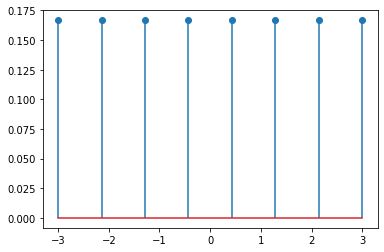

In [3]:
num_fourier=10
num_qubits = 3
xlower = -3
xupper = 3
xupper_extension = 0.5*(3*xupper - xlower) 
distribution = stats.uniform(xlower, xupper-xlower)
# distribution = stats.norm(1, 1)
num_points = 2**num_qubits
x_piecewise = [xlower, xupper, xupper_extension]
pdf_domain_points = np.linspace(x_piecewise[0], x_piecewise[1], 2**num_qubits)
pdf = distribution.pdf(pdf_domain_points)
xpoints = np.linspace(xlower, xupper, num_points) 
plt.stem(xpoints, pdf)

## Define extended F(x)

array([594.          +0.j        , 151.70872481+297.51486975j,
       -33.35425474 +30.03349404j,  -8.56480493  -4.60063198j,
        -6.55568903  +0.65197719j, -10.13714602  -2.46190562j,
        -8.09223174  -4.75705769j,  -7.63722179  -4.08158576j,
        -8.12281859  -4.96669614j,  -7.32323453  -5.77037279j,
        -6.96928462  -5.79347954j])

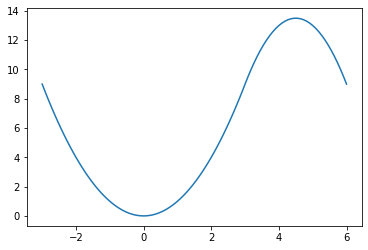

In [4]:
func = lambda x: x**2
def recast(array):
    array[0] += array[-1]
    array[0] /= 2
    array[-1] = 0
    return array

func_derivative = lambda x: 2*x

x = np.linspace(xlower, xupper_extension, 100, endpoint=True) 

Func = periodic_extension(func, func_derivative, xlower, xupper, xupper_extension)
coeffs = fft_coeffs(recast(Func(x)), 10)


plt.plot(x, Func(x))
coeffs

In [15]:
def integral(qc, n, beta, omega, delta, xlower, epsilon=0.01):
    alpha = n*omega*xlower - beta
    theta = n*omega * delta
    backend = Aer.get_backend('aer_simulator')
    phase_good = amplitude_estimation(qc, alpha, theta, epsilon=epsilon, conf_lvl=0.05, backend=backend) 
    return 1 - 2* phase_good

def sum_estimation(pdf, fourier_coeffs, x_piecewise, epsilon=0.01):
    num_points = pdf.shape[0]
    xlower, xupper, xupper_extension = x_piecewise
    period = xupper_extension- xlower
    omega = 2*np.pi /period
    delta = (xupper-xlower)/(num_points - 1)
    print(omega, delta)
    pdf_normalized = pdf/pdf.sum()
    pdf_amplitudes = np.sqrt(pdf_normalized)
    qc = create_cirquit(pdf_amplitudes)

    num_fourier = fourier_coeffs.shape[0]-1
    for n in range(1, num_fourier):
        cos_sum = integral(qc, n, 0, omega, delta, xlower, epsilon=epsilon)
        sin_sum = integral(qc, n, np.pi/2, omega, delta, xlower, epsilon=epsilon)
        fourier_coeffs.real[n] *= cos_sum
        fourier_coeffs.imag[n] *= sin_sum
        
    s = np.fft.irfft(fourier_coeffs, 100)

    return s


def plot_fourier(fourier_coeffs, x):
    fig, ax = plt.subplots(figsize=(10, 5))
    y = np.fft.irfft(fourier_coeffs, len(x))#*len(x)
    ax.plot(x, y)
    return ax

0.6981317007977318 0.8571428571428571


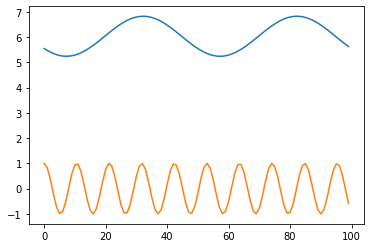

In [20]:

expected_value_quantum = sum_estimation(pdf, coeffs, x_piecewise, epsilon=0.01)
fig, ax = plt.subplots()
x = np.arange(100)
ax.plot(expected_value_quantum)
ax.plot(np.cos(0.698*0.85*x))

## Classical MCI

In [7]:
num_samples = 10000000
samples = distribution.rvs(size=num_samples)
expected_value_classical = func(samples).sum()/num_samples
expected_value_classical 

3.000371017721837

In [8]:
(xupper-xlower)**2/12

3.0

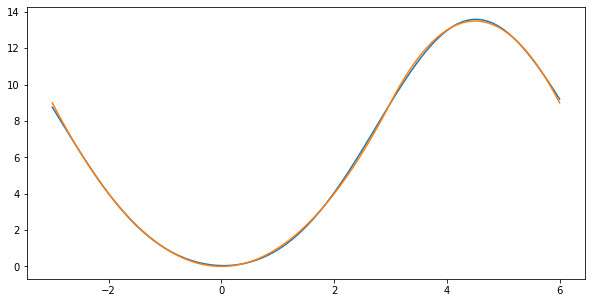

In [9]:
coeffs = fft_coeffs(Func(x), 2)
coeffs
ax = plot_fourier(coeffs, x)
ax.plot(x, Func(x))

In [10]:
coeffs

array([603.          +0.j        , 160.69096537+298.07998443j,
       -24.42522242 +31.16149314j])